# Import Files

In [ ]:
import kagglehub
import pandas as pd
import os

# Ensure Google Drive is mounted
from google.colab import drive
drive.mount('/content/drive')

# Define the save path
save_path = "/content/drive/MyDrive/Final Project/data"
os.makedirs(save_path, exist_ok=True)  # Create the directory if it doesn't exist

# Download the dataset
path = kagglehub.dataset_download("sobhanmoosavi/us-accidents")

# Locate the CSV file in the directory
file_path = os.path.join(path, "US_Accidents_March23.csv")

# Load the dataset
df = pd.read_csv(file_path, nrows=5000)  # Read the first 5000 rows

# Save the dataset to the specified directory
save_file_path = os.path.join(save_path, "US_Accidents_Sample.csv")
df.to_csv(save_file_path, index=False)

# Confirm the save
print(f"Dataset saved to: {save_file_path}")
print(df.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset saved to: /content/drive/MyDrive/Final Project/data/US_Accidents_Sample.csv
    ID   Source  Severity           Start_Time             End_Time  \
0  A-1  Source2         3  2016-02-08 05:46:00  2016-02-08 11:00:00   
1  A-2  Source2         2  2016-02-08 06:07:59  2016-02-08 06:37:59   
2  A-3  Source2         2  2016-02-08 06:49:27  2016-02-08 07:19:27   
3  A-4  Source2         3  2016-02-08 07:23:34  2016-02-08 07:53:34   
4  A-5  Source2         2  2016-02-08 07:39:07  2016-02-08 08:09:07   

   Start_Lat  Start_Lng  End_Lat  End_Lng  Distance(mi)  ... Roundabout  \
0  39.865147 -84.058723      NaN      NaN          0.01  ...      False   
1  39.928059 -82.831184      NaN      NaN          0.01  ...      False   
2  39.063148 -84.032608      NaN      NaN          0.01  ...      False   
3  39.747753 -84.205582      NaN      NaN          0.01  ...

In [ ]:
# 1. Remove irrelevant or textual columns
# -----------------------------------------------------------------
# These columns are removed because:
# - 'ID': It is an identifier of each crash, but doesn't give any
#            useful information for modeling.
# - 'Source': Again, It does not provide useful information for modeling.
# - 'Description': Textual data, and the project specifies avoiding NLP tasks.
# - Location columns ('Street', 'City', etc.): These are redundant because
#   location information is already captured in coordinates.
columns_to_drop = [
    'ID', 'Source', 'Description', 'Street', 'City',
    'County', 'State', 'Zipcode', 'Country', 'Timezone', 'Airport_Code'
]
df = df.drop(columns=columns_to_drop, errors='ignore')  # Avoid errors if columns are missing

# 2. Convert Wind_Direction to degrees
# -----------------------------------------------------------------
# 'Wind_Direction' is converted into degrees because:
# - Directions like 'N', 'S', 'E', etc., are categorical in nature but have
#   a natural order in a circular format (e.g., North = 0°, East = 90°, etc.).
# - Converting them to degrees provides a numeric representation that preserves
#   this order and makes the feature usable in models.
wind_direction_mapping = {
    'N': 0, 'NNE': 22.5, 'NE': 45, 'ENE': 67.5,
    'E': 90, 'ESE': 112.5, 'SE': 135, 'SSE': 157.5,
    'S': 180, 'SSW': 202.5, 'SW': 225, 'WSW': 247.5,
    'W': 270, 'WNW': 292.5, 'NW': 315, 'NNW': 337.5,
    None: None, 'Variable': None  # Handle missing or "Variable"
}
df['Wind_Direction'] = df['Wind_Direction'].map(wind_direction_mapping)

# 3. Convert Weather_Condition to integers
# -----------------------------------------------------------------
# 'Weather_Condition' is converted to integer categories because:
# - It is currently textual data with multiple unique values, which is unsuitable
#   for direct use in machine learning models.
# - Assigning each unique weather condition an integer value simplifies storage
#   and makes the data usable for models.
# - The mapping is also printed for reference to interpret results after training.
df['Weather_Condition'] = df['Weather_Condition'].astype('category')

# Retrieve and print the mapping for Weather_Condition
weather_mapping = dict(enumerate(df['Weather_Condition'].cat.categories))
print("Weather Condition Mapping:")
for code, condition in weather_mapping.items():
    print(f"{code}: {condition}")

# Replace Weather_Condition column with numerical codes
df['Weather_Condition'] = df['Weather_Condition'].cat.codes

# 4. Combine Day/Night columns into a single column (Daytime)
# -----------------------------------------------------------------
# The columns 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
# and 'Astronomical_Twilight' determine if the time is "Day" or "Night".
# - Maintaining all four is redundant, as the information overlaps.
# - We combine them into a single column 'Daytime':
#   - If two or more columns indicate "Day," then 'Daytime' = 1 (indicating daytime).
#   - Otherwise, 'Daytime' = 0 (indicating nighttime).
# - This simplifies the dataset while retaining the key information.
day_night_columns = ['Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight']

# Replace "Day" with 1 and "Night" with 0 for all four columns
df[day_night_columns] = df[day_night_columns].replace({'Day': 1, 'Night': 0})

# Explicitly infer the appropriate data types after replacement
df[day_night_columns] = df[day_night_columns].infer_objects(copy=False)

# Create the Daytime column: 1 if two or more columns are 1, otherwise 0
df['Daytime'] = (df[day_night_columns].sum(axis=1) >= 2).astype(int)

# Drop the original Day/Night columns
df = df.drop(columns=day_night_columns)

# 5. Convert all True/False values to 1 and 0
# -----------------------------------------------------------------
# Replace True with 1 and False with 0 for the entire dataset
df = df.replace({True: 1, False: 0})

# 6. Convert timestamp columns to Unix timestamp integers
# -----------------------------------------------------------------
# List of timestamp columns
timestamp_columns = ['Start_Time', 'End_Time', 'Weather_Timestamp']

# Convert each timestamp column to datetime and then to Unix time
for col in timestamp_columns:
    df[col] = pd.to_datetime(df[col])  # Convert to datetime
    df[col] = df[col].astype('int64') // 10**9  # Convert to Unix time (seconds since epoch)


# 7. Handle missing values in Wind_Chill(F), End_Lng, End_Lat, and other columns
# -----------------------------------------------------------------
# - Replace NaN with an out-of-range placeholder (-9999) for numerical columns.
# - Add missing indicator columns for each to retain information about missingness.

# Define columns to handle
columns_to_handle = [
    'Wind_Chill(F)', 'End_Lng', 'End_Lat', 'Temperature(F)', 'Humidity(%)',
    'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)',
    'Precipitation(in)'
]

# Add missing indicators for all columns
for col in columns_to_handle:
    missing_indicator_col = f"{col}_Missing"
    df[missing_indicator_col] = df[col].isna().astype(int)

# Replace NaN with -9999 (out-of-range placeholder) for all columns
for col in columns_to_handle:
    df[col] = df[col].fillna(-9999)

# 8. Confirm the cleaned DataFrame
# -----------------------------------------------------------------
print("\nCleaned DataFrame:")
print(df.head())


# Save the cleaned dataset to overwrite the existing CSV file
df.to_csv(save_file_path, index=False)

Weather Condition Mapping:
0: Clear
1: Cloudy
2: Drizzle
3: Fog
4: Haze
5: Heavy Rain
6: Light Drizzle
7: Light Freezing Drizzle
8: Light Freezing Rain
9: Light Rain
10: Light Rain Showers
11: Light Snow
12: Mist
13: Mostly Cloudy
14: Overcast
15: Partly Cloudy
16: Rain
17: Scattered Clouds
18: Shallow Fog
19: Smoke
20: Snow

Cleaned DataFrame:
   Severity  Start_Time    End_Time  Start_Lat  Start_Lng  End_Lat  End_Lng  \
0         3  1454910360  1454929200  39.865147 -84.058723  -9999.0  -9999.0   
1         2  1454911679  1454913479  39.928059 -82.831184  -9999.0  -9999.0   
2         2  1454914167  1454915967  39.063148 -84.032608  -9999.0  -9999.0   
3         3  1454916214  1454918014  39.747753 -84.205582  -9999.0  -9999.0   
4         2  1454917147  1454918947  39.627781 -84.188354  -9999.0  -9999.0   

   Distance(mi)  Weather_Timestamp  Temperature(F)  ...  \
0          0.01         1454911080            36.9  ...   
1          0.01         1454910660            37.9  ...   
2

<ipython-input-8-a63424f22521>:63: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[day_night_columns] = df[day_night_columns].replace({'Day': 1, 'Night': 0})
<ipython-input-8-a63424f22521>:77: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({True: 1, False: 0})


<ipython-input-9-73957f8bed8c>:8: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df[numerical_columns].hist(bins=20, color='skyblue', edgecolor='black', ax=axes)


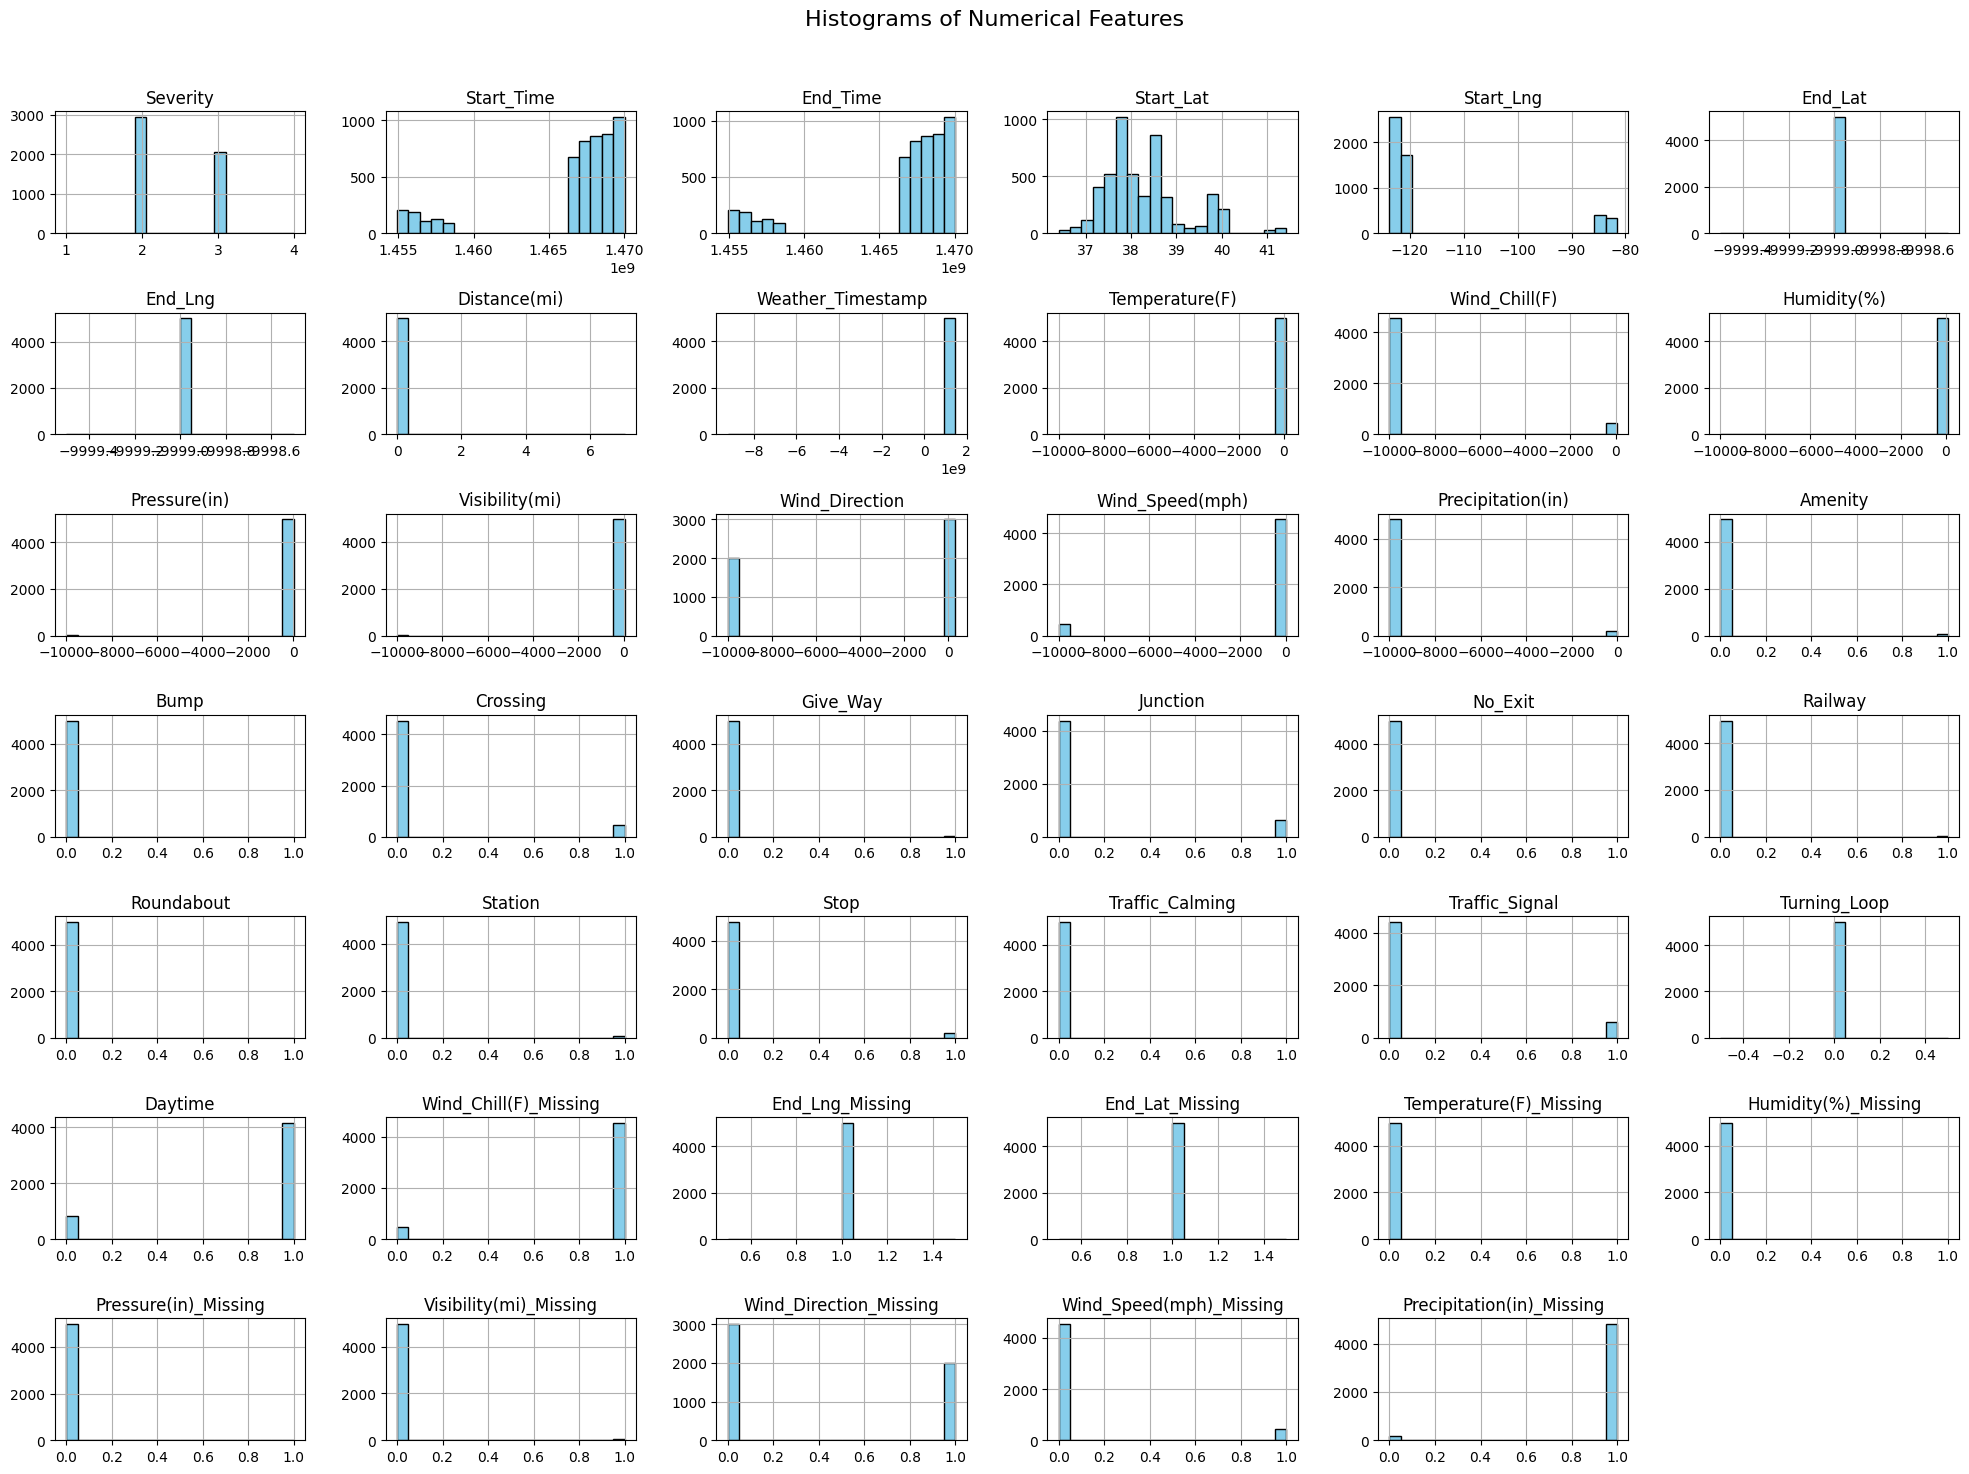

In [ ]:
import matplotlib.pyplot as plt

# Select numerical columns
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Plot histograms
fig, axes = plt.subplots(figsize=(20, 15))
df[numerical_columns].hist(bins=20, color='skyblue', edgecolor='black', ax=axes)

# Add a title
plt.suptitle('Histograms of Numerical Features', fontsize=16)

# Use tight layout to avoid overlapping labels and titles
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust rect to leave space for suptitle
plt.show()


# Plot the Frequency of each Weather Condition

It is notable from the graph that the most frequent weather condition in the dataset is clear weather. Perhaps drivers tend to act more carefully in adverse conditions, but tend to become more careless during clear weather.

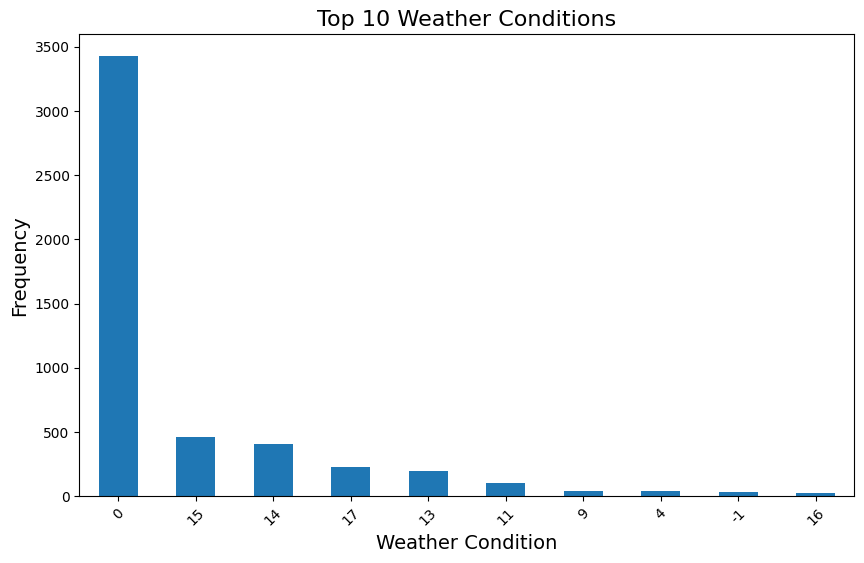

In [ ]:
# Bar plot for Weather_Condition distribution
df['Weather_Condition'].value_counts().head(10).plot(kind='bar', figsize=(10, 6))
plt.title('Top 10 Weather Conditions', fontsize=16)
plt.xlabel('Weather Condition', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=45)
plt.show()


# Plot the frequency of each severity

It is notable from this plot that the dataset consists mostly of medium-severity accidents. This could be because very serious accidents are rare, and because drivers don't tend to report low-severity accidents

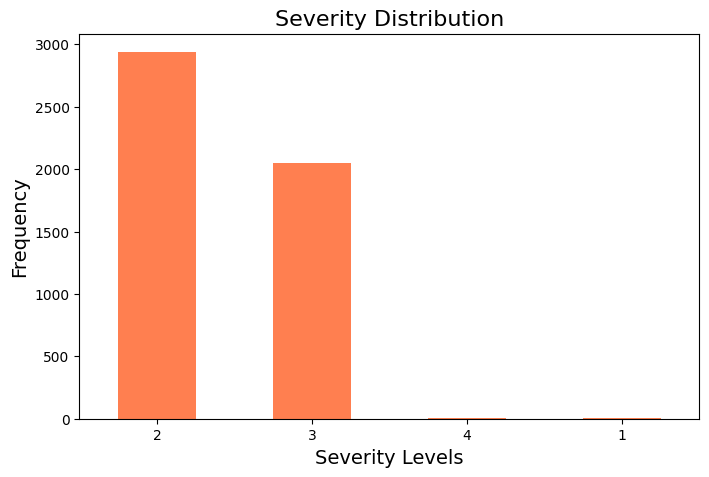

Severity Distribution (%):
Severity
2    58.76
3    41.06
4     0.10
1     0.08
Name: count, dtype: float64


In [ ]:
# Severity class distribution
severity_counts = df['Severity'].value_counts()

# Plot severity distribution
severity_counts.plot(kind='bar', color='coral', figsize=(8, 5))
plt.title('Severity Distribution', fontsize=16)
plt.xlabel('Severity Levels', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(rotation=0)
plt.show()

# Print percentages
print("Severity Distribution (%):")
print((severity_counts / len(df) * 100).round(2))


In [ ]:
 %%shell
 jupyter nbconvert --to html "/content/drive/MyDrive/Final Project/Phase 1/Phase 1.ipynb"

[NbConvertApp] Converting notebook /content/drive/MyDrive/Final Project/Phase 1/Phase 1.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 3 image(s).
[NbConvertApp] Writing 622255 bytes to /content/drive/MyDrive/Final Project/Phase 1/Phase 1.html
